Originally downloaded from: https://jmetzen.github.io/2015-11-27/vae.html <br>
And referenced from: https://github.com/kvfrans/variational-autoencoder

# Variational Autoencoder in TensorFlow

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Note: The post was updated on January 3rd 2017:
  * changes required for supporting TensorFlow v0.12 and Python 3 support

Let us first do the necessary imports, load the data (MNIST), and define some helper functions.

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [9]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py
import tf_autoencoder.mnist_input_data as input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
print(len(mnist.train.next_batch(2)[0]), len(mnist.train.next_batch(2)[1]))
print(len(mnist.train.next_batch(2)[0][1]), len(mnist.train.next_batch(2)[1][1]))
print(mnist.train.next_batch(2)[1])
print(mnist.train.next_batch(2)[0].shape)

2 2
784 10
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
(2, 784)


In [11]:
# moved to tf_autoencoder.xavinit
from tf_autoencoder import xavinit

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [12]:
# moved to tf_autoencoder.vae
from tf_autoencoder import vae
from tf_autoencoder import vae_orig

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don't need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [13]:
# moved to tf_autoencoder.train
from tf_autoencoder import train

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [14]:
reload(vae)
reload(vae_orig)
reload(train)

netarch = {'n_input':784,          # MNIST data input (img shape: 28*28)
           'n_hidden_recog_1':500, # 1st layer encoder neurons
           'n_hidden_recog_2':500, # 2nd layer encoder neurons
           'n_z':20,               # dimensionality of latent space
           'n_hidden_gener_1':500, # 1st layer decoder neurons
           'n_hidden_gener_2':500} # 2nd layer decoder neurons

# Using RMSE requires a correction factor because the reconstruction loss needs to be much
# greater than the latent loss.  Otherwise, the latent loss will be optimized away without
# any improvement to the reconstruction loss.  The correction factor makes the two losses
# effectively compete against each other; while the reconstruction loss is shrinking, the
# latent loss is growing--similar to as if its purpose was for regularization, which is
# exactly its intent.  In this case the reconstruction loss should from around 160 down to
# to around 80 while the latent loss should grow from around 8 up to 20.
rc = 20.0

use_orig = False
untrained_vae = (vae_orig if use_orig else vae).VariationalAutoencoder(netarch,
                                                                       learning_rate=0.001,
                                                                       corruption_level=0.2,
                                                                       use_rmse=True,
                                                                       rmse_correction=rc)

mnist.train.n_points = mnist.train.num_examples
mnist.validation.n_points = mnist.validation.num_examples

# <#iters>=<rmse>: 75=0.1046, 26=0.1155, 2=0.1663, 1=0.2185
# <corruption_level>=<rmse> (26 iters): 0.0=0.1192, 0.3=0.1202, 0.5=0.1286, 0.6=0.1354
trained_vae = train.train(untrained_vae, mnist.train, None, training_epochs=75,
                          batch_size=100, display_step=5)

/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2017-03-10 08:59:38,798 : INFO : Training on 55000 data points
2017-03-10 08:59:55,626 : INFO : Epoch: 001 cost=186.7 (121.6 +60.8 +3.23; d=32%) rmse=0.2428
2017-03-10 08:59:55,627 : INFO :           [0.228, 0.198, 0.306, 0.462, 0.585] avg=0.356 stdev=0.147
2017-03-10 09:00:11,947 : INFO : Epoch: 002 cost=155.1 (96.4 +48.2 +9.67; d=31%) rmse=0.1924
2017-03-10 09:00:11,948 : INFO :           [0.291, 0.242, 0.279, 0.379, 0.424] avg=0.323 stdev=0.068
2017-03-10 09:00:28,285 : INFO : Epoch: 003 cost=141.6 (85.6 +42.8 +12.07; d=30%) rmse=0.1709
2017-03-10 09:00:28,286 : INFO :           [0.297, 0.254, 0.273, 0.349, 0.361] avg=0.307 stdev=0.042
2017-03-10 09:00:44,714 : INFO : Epoch: 004 cost=135.0 (80.1 +4

Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

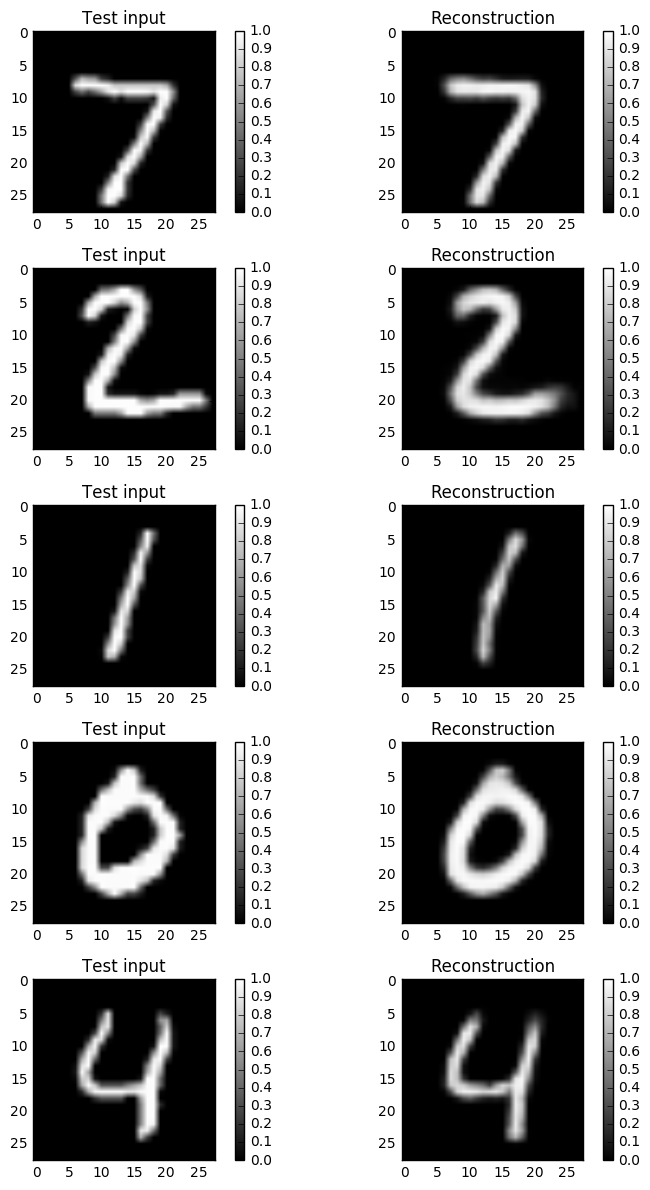

In [15]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = trained_vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [16]:
netarch = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

untrained_vae2d = vae.VariationalAutoencoder(netarch, learning_rate=0.001)#, corruption_level=0.0)

trained_vae2d = train.train(untrained_vae2d, mnist.train, None, training_epochs=40,
                            batch_size=100, display_step=5) # final RMSE: 0.1198 (cl=0.3)

/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2017-03-10 09:23:53,672 : INFO : Training on 55000 data points
2017-03-10 09:24:10,138 : INFO : Epoch: 001 cost=190.5 (130.5 +56.0 +2.97; d=29%) rmse=0.2428
2017-03-10 09:24:10,139 : INFO :           [0.224, 0.188, 0.296, 0.454, 0.581] avg=0.349 stdev=0.148
2017-03-10 09:24:25,963 : INFO : Epoch: 002 cost=167.6 (113.7 +48.8 +4.64; d=29%) rmse=0.2228
2017-03-10 09:24:25,964 : INFO :           [0.261, 0.206, 0.276, 0.412, 0.516] avg=0.334 stdev=0.113
2017-03-10 09:24:41,830 : INFO : Epoch: 003 cost=162.8 (110.2 +47.2 +4.92; d=29%) rmse=0.2177
2017-03-10 09:24:41,830 : INFO :           [0.268, 0.211, 0.273, 0.402, 0.5] avg=0.331 stdev=0.105
2017-03-10 09:24:57,579 : INFO : Epoch: 004 cost=159.6 (107.8 +4

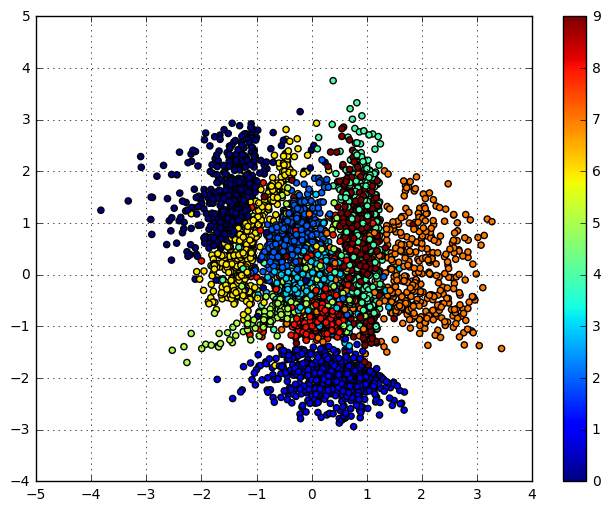

In [17]:
reload(vae)
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = trained_vae2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

### ML seems to "learn circles" when it reduces dimensionality.  What I mean by this is that it organizes different things into different parts/clusters of a lower dimensional space in a circular-like fashion.  This is similar, perhaps, to how you can represent temporal cycles in a circle by converting them from repeating into 2 dims (e.g. convert days of week from 0-6 to--in polar coordinates--(0,1), (pi/3,1), (2pi/3,1) ... (5pi/3,1)).

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

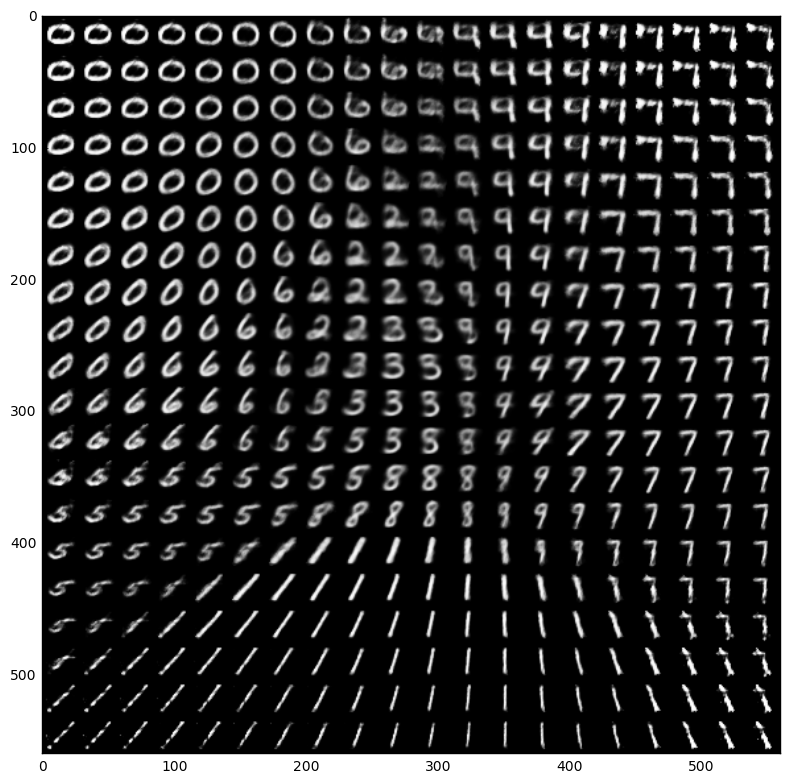

In [18]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])#*vae.batch_size)
        x_mean = trained_vae2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.